# Reading data

In [1]:
import numpy as np
import math
import tqdm

In [2]:
def read_dataset(index):
    with open('../data/' + str(index) + '.txt', 'r') as inf:
        m = int(inf.readline())
        n = int(inf.readline())
        X_train, y_train = [], []
        for i in range(n):
            obj = list(map(int, inf.readline().split()))
            X_train.append(obj[:-1])
            y_train.append(obj[-1])
        n = int(inf.readline())
        X_test, y_test = [], []
        for i in range(n):
            obj = list(map(int, inf.readline().split()))
            X_test.append(obj[:-1])
            y_test.append(obj[-1])
        
    return X_train, y_train, X_test, y_test

# Hyperparameter optimization and NRMSE

In [3]:
import sys
sys.path.append('../../../cf')
from sgd_D import SGDClassifier 

In [4]:
def count_nrmse(y_predicted, y_test):
    return math.sqrt(sum((y_pred - y_t) ** 2 for y_pred, y_t in zip(y_predicted, y_test))) / len(y_test) / (max(y_test) - min(y_test))

In [5]:
def hyperparameter_optimization(X_train, y_train, X_test, y_test, Model):
    best_nrmse = 1
    for epochs_count in tqdm.tqdm(range(1000, 11000, 1000)):
        for lr in [1e-20, 1e-15,1e-10,1e-5, 1e-3]:
            for reg_coef in [0.7, 0.9, 1]:
                params = [epochs_count, lr, reg_coef]
                model = Model(epochs_count, lr, reg_coef)
                model.fit(X_train, y_train)
                y_predicted = model.predict(X_test)
                nrmse = count_nrmse(y_predicted, y_test)
                if nrmse < best_nrmse:
                    best_nrmse = nrmse
                    best_params = params
                    print("Finished with best params", best_params, nrmse)
    print('Overall best params:', best_params)
    print('Overall best nrmse:', best_nrmse)
    return best_params, best_nrmse

# Analyzing best model

In [6]:
import seaborn as sns
import pandas as pd

In [7]:
def plot(test, train):
    plot_data = pd.DataFrame({"test": pd.Series(test), "train": pd.Series(train)})
    sns.lineplot(data=plot_data)

# Stochastic gradient descent

In [8]:
X_train, y_train, X_test, y_test = read_dataset(1)
hyperparameter_optimization(X_train, y_train, X_test, y_test, SGDClassifier)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Finished with best params [1000, 1e-20, 0.7] 0.030061680568040632
Finished with best params [1000, 1e-20, 0.9] 0.030058652312675835
Finished with best params [1000, 1e-20, 1] 0.029619879095482058
Finished with best params [1000, 1e-15, 0.7] 0.010198272461941974
Finished with best params [1000, 1e-15, 1] 9.396984273355118e-06


 50%|█████████████████████████████████████████▌                                         | 5/10 [02:38<02:22, 28.60s/it]

Finished with best params [6000, 1e-15, 1] 6.89925349437669e-06


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [05:29<00:00, 32.90s/it]

Overall best params: [6000, 1e-15, 1]
Overall best nrmse: 6.89925349437669e-06


([6000, 1e-15, 1], 6.89925349437669e-06)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 983.99it/s]


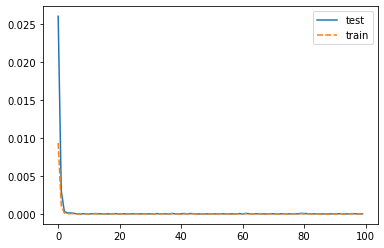

In [9]:
best_params = [9000, 1e-15, 1]
model = SGDClassifier(*best_params)
model.fit(X_train, y_train, False)
test_nrmses = []
train_nrmses = []
for i in tqdm.tqdm(range(10000)):
    model.process_step()
    if i % 100 == 0:
        y_predicted_test = model.predict(X_test)
        test_nrmses.append(count_nrmse(y_predicted_test, y_test))
        y_predicted_train = model.predict(X_train)
        train_nrmses.append(count_nrmse(y_predicted_train, y_train))
plot(test_nrmses, train_nrmses)

In [10]:
stochastic_overall = test_nrmses

# Least squares

In [11]:
class LSClassifier:
    def __init__(self):
        pass
    def fit(self, X_train, y_train):
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        u, s, v = np.linalg.svd(X_train, full_matrices=False)
        s = np.linalg.inv(np.diag(s))
        self.answer = v.T.dot(s).dot(u.T).dot(y_train)
    def predict(self, X_test):
        return [sum(w * x_st for w, x_st in zip(self.answer.tolist(), element)) for element in X_test]

In [12]:
X_train, y_train, X_test, y_test = read_dataset(1)
model = LSClassifier()
model.fit(X_train, y_train)
train_nrmses=[count_nrmse(model.predict(X_train), y_train) for i in range(100)]

In [13]:
X_train, y_train, X_test, y_test = read_dataset(1)
model = LSClassifier()
model.fit(X_train, y_train)
test_nrmses=[count_nrmse(model.predict(X_test), y_test) for i in range(100)]

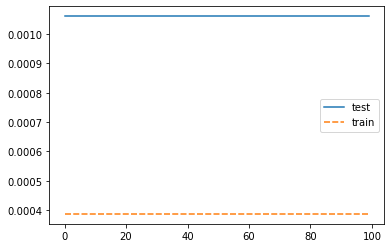

In [14]:
plot(test_nrmses, train_nrmses)

In [15]:
overall_least_squares = test_nrmses

# Genetic algorithm

In [16]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [17]:
from geneticalgorithm import geneticalgorithm as ga

 The best solution found:                                                                           
 [ 7.33090551e+01  3.94912939e+01 -3.78149475e+01 -7.92084882e+01
 -9.03496935e+01  5.35659270e+01 -2.30440077e+00  1.44676244e+01
  5.19938170e+01 -1.93894543e+01  9.83010679e+01  9.23570375e+00
  6.07276601e+01 -9.23997892e+01  5.69697860e+00 -3.19032717e+01
  3.55926913e+00 -8.32532124e+01  7.10386854e+01 -4.80876077e+01
  4.66817531e+01  5.23015187e+01  3.11230368e+01 -7.27413578e+01
 -7.47334160e+01 -8.40348951e+01 -2.92627064e+00  5.61515507e+01
 -7.04507342e+01 -3.48641505e+01 -7.19821673e+01  1.44526447e+01
  7.08849906e+01 -4.46645974e+01 -5.82192111e+01  7.56484135e+01
  1.81588959e+01 -4.83129264e+01 -5.51552292e+01  7.30609673e+01
 -7.16608655e+01 -8.15918939e+01 -3.20546814e+01 -4.54661528e+01
 -4.92668762e+01 -9.95292862e+01  3.12158641e+00  9.65788162e+01
  9.27628038e+01  8.70803833e+01 -8.21248204e+01 -8.99304878e+01
  4.97384064e+00  9.85494458e+01 -8.66696595e+01 -7.3

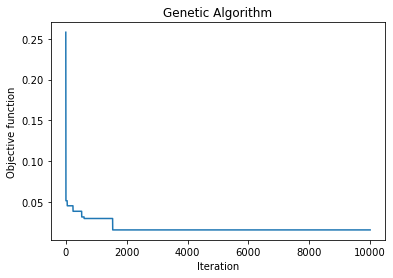

In [18]:
def f(X):
    return count_nrmse(X_train.dot(X).tolist(), y_train)
    
    
varbound=np.array([[-100,100]]*X_train.shape[1])

algorithm_param = {'max_num_iteration': 10000,
                   'population_size':10,
                   'mutation_probability':0.1,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type':'uniform',
                   'max_iteration_without_improv':None}

model=ga(function=f,dimension=X_train.shape[1],variable_type='real',variable_boundaries=varbound, algorithm_parameters=algorithm_param)

model.run()

In [19]:
nrmse_train = model.report

 The best solution found:                                                                           
 [ 2.48027347e+01 -8.42515308e-01 -9.27221194e+01 -1.47317633e+01
  8.92202808e+01  2.96536945e+01 -4.64195516e+01  8.90349239e+01
 -6.97208964e+01  6.99537335e+00  9.89062393e+01  1.76316418e+01
 -6.15719769e+01  1.86008991e+01 -3.72444330e+01 -4.41330490e+01
  4.09266348e+00 -5.59266320e+01 -2.04179495e+01  2.21527730e+01
  8.03719844e+01 -9.43966377e+01 -8.73600028e+01  3.12495471e+01
  1.72218405e+01  4.16460995e+01 -8.27821400e+01  4.70973672e+01
 -9.21117479e+01 -6.18234737e+01  8.75877114e+01 -1.84775718e+01
  5.25257203e+01  5.01138383e+00  1.34378066e+01 -4.60618564e+01
  8.45877614e+01  6.20722942e+00  3.13843243e+01  8.73277567e+01
 -1.73786403e+01  8.03029845e+01 -8.34149474e+01 -1.51605515e+01
 -1.71992490e+01  1.06811406e+01  5.13931992e+01 -1.28778774e+01
  2.83494486e+01  5.64348249e+01 -3.43958951e+01  3.27369094e+01
  9.72992280e+01  8.32085837e+01 -8.97044989e+01 -4.7

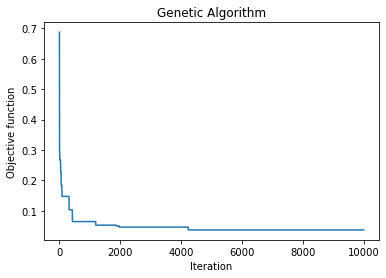

In [20]:
def f(X):
    return count_nrmse(X_test.dot(X).tolist(), y_test)
    
    
varbound=np.array([[-100,100]]*X_train.shape[1])

algorithm_param = {'max_num_iteration': 10000,
                   'population_size':10,
                   'mutation_probability':0.1,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type':'uniform',
                   'max_iteration_without_improv':None}

model=ga(function=f,dimension=X_test.shape[1],variable_type='real',variable_boundaries=varbound, algorithm_parameters=algorithm_param)

model.run()

In [21]:
nrmse_test = model.report

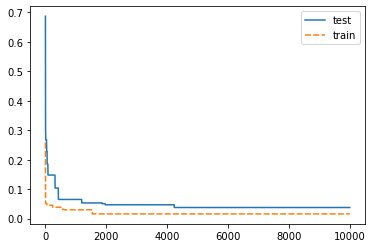

In [22]:
plot(nrmse_test, nrmse_train)

In [23]:
genetic_overall = []
for i, e in enumerate(nrmse_test):
    if i % 100 == 0:
        genetic_overall.append(e)

# Overall algos analysis

In [24]:
nrmse = pd.DataFrame({'genetic': pd.Series(genetic_overall), 'least_squares': pd.Series(overall_least_squares), 'sgd': pd.Series(stochastic_overall)})

In [25]:
nrmse

,genetic,least_squares,sgd
0,0.686767,0.001061,0.025985
1,0.147833,0.001061,0.003058
2,0.147833,0.001061,0.000324
3,0.147833,0.001061,0.000115
4,0.103738,0.001061,0.000138
...,...,...,...
96,0.037706,0.001061,0.000037
97,0.037706,0.001061,0.000011
98,0.037706,0.001061,0.000009
99,0.037706,0.001061,0.000019


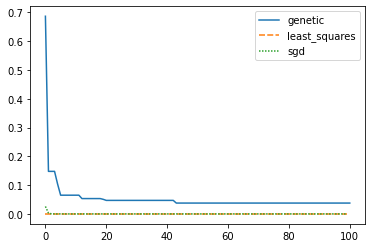

In [26]:
sns.lineplot(data=nrmse)